In [2]:
# %load_ext autoreload
# %autoreload 2

In [1]:
import io
import numpy as np
from datetime import datetime
import pandas as pd

import pycuda.autoprimaryctx
import skcuda
import skcuda.misc
skcuda.misc.init()


import inspect
import matplotlib as mpl
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from neural.network import Network
from sklearn.metrics import pairwise_distances
from antennal_lobe.experiments.differential_evolution import DifferentialEvolutionSolver as DESolver
from neural.utils import generate_stimulus
from itertools import product
from tqdm import tqdm
from example_model_and_params import *
from utils import *
from matplotlib.gridspec import GridSpec
from copy import deepcopy
import skopt
from lhs import Lhs

In [2]:
DEFAULT_PARAMS = {
    'osn_axt': {'a1': 100., 'b1': 3.12, 'k': 100000.0},
    'osn-to-preln': {'a1': 1.0, 'b1': 15.5, 'gmax': 3232.6},
    'osn-to-posteln': {
        'a1': 1.,
        'b1': 1.4540529550164887,
        'k': 323039.26691518247,
        'a2': 1.,
        'b2': 98.82274646620965,
        'a3': 1.,
        'b3': 5.9266873782378555,
        'gmax': 67918770.0
    },
    'osn-to-postiln': {
        'a1': 1.,
        'b1': 81.30204837646579,
        'k': 384165.1012001436,
        'a2': 1.,
        'b2': 3.657942885692797,
        'a3': 1.,
        'b3': 85.33405338413093,
        'gmax': 516779.02440091287
    },
    'osn_axt-to-pn': {'a1': 1.0, 'b1': 100.0, 'gmax': 122655.1543619},
    'posteln-to-pn': {'a1': 1.0, 'b1': 100.0, 'gmax': 216734.63869500003},
    'postiln-to-pn': {'a1': 1.0, 'b1': 100.0, 'gmax': -25705.851600500002},
    'osn_bsg': {'sigma': 0.0025},
    'pn_bsg': {'sigma': 0.0014},
    'preln_bsg': {'sigma': 0.0},
    'posteln_bsg': {'sigma': 0.0},
    'postiln_bsg': {'sigma': 0.0}
}

## Estimate Synaptic Current from Phsyiology Data

In [9]:
df_aff = pd.read_csv('../data/estimated_affinity.csv', index_col=0)
aff = df_aff.loc['acetone']
aff_or59b = df_aff.loc['acetone', '59b'] # affinity rate of acetone for or59b
dr = 10. # dissosciation rate
print(aff_or59b, dr)

0.0021458652039877 10.0


In [12]:
data = np.load('../data/staircase.npz', allow_pickle=True)
t = data['t']
dt = t[1] - t[0]
stim = data['pn_input'][2]
pn = data['pn_output'][2]
pn_all = np.outer(aff/aff_or59b, pn)
pn_I = estimate_current(pn_all, resting=1)
_, _, pn_I_ss, pn_I_pk = decompose_signal(t, stim, pn_I)
pn_I_on = np.clip(pn_I_pk, 0, np.inf)
pn_I_off = np.clip(pn_I_pk, -np.inf, 0)

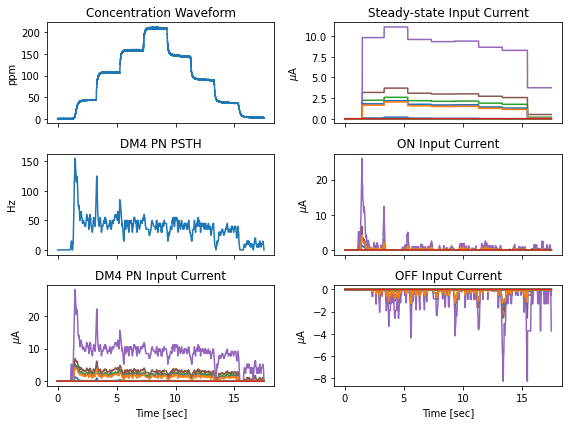

In [13]:
fig, axes = plt.subplots(3,2, figsize=(8,6), sharex=True)
axes[0,0].plot(t, stim)
axes[0,0].set(ylabel='ppm', title='Concentration Waveform')
axes[1,0].plot(t, pn)
axes[1,0].set(ylabel='Hz', title='DM4 PN PSTH')
axes[2,0].plot(t, pn_I.T)
axes[2,0].set(ylabel='$\mu$A', title='DM4 PN Input Current', xlabel='Time [sec]')
axes[0,1].plot(t, pn_I_ss.T)
axes[0,1].set(ylabel='$\mu$A', title='Steady-state Input Current')
axes[1,1].plot(t, pn_I_on.T)
axes[1,1].set(ylabel='$\mu$A', title='ON Input Current')
axes[2,1].plot(t, pn_I_off.T)
axes[2,1].set(ylabel='$\mu$A', title='OFF Input Current', xlabel='Time [sec]')
fig.tight_layout()

## Simulate Or59b OSN BSG Response to accelerate LN pathway simulation

In [19]:
# nn_osn = Network(solver="euler")
# inp = nn_osn.input(num=1, name='stim')
# osn_otp = nn_osn.add(OTP, num=len(aff), br=dr*aff.values, dr=dr, name='OSN-OTP')
# osn_bsg = nn_osn.add(PoissonCSN, num=len(aff), name='OSN-BSG')

# osn_otp(stimulus=inp)
# osn_bsg(I=osn_otp.I)
# osn_bsg.record('x')

# nn_osn.compile()
# inp(garray.to_gpu(np.ascontiguousarray(stim)))
# nn_osn.run(dt, verbose=True)


/mnt/server-home/tingkai/Project/NEURAL/neural/neural/network/network.py:324: UserWarning: Size mismatches: OSN-OTP(24) <- stim(1)
  warnings.warn(


  0%|          | 0/175000 [00:00<?, ?it/s]

In [21]:
# osn_bsg_spikerate = osn_bsg.recorder.x
# np.savez('acetone_multichannel_osn_bsg_psth', osn_bsg_spikerate)

In [22]:
osn_bsg_spikerate = np.load('acetone_multichannel_osn_bsg_psth.npz')['arr_0']

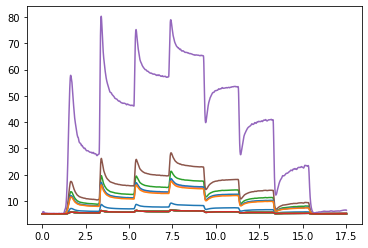

In [24]:
_ = plt.plot(t, osn_bsg_spikerate.T/dt)

## Define LN Pathway Simulation Helper Functions

In [25]:
def create_network(
    model: str, Npop:int, N_r:int, params_dct: tp.Dict, dt: float, 
    /, 
    dtype=float, record_rate: int = 1, verbose:bool = True
) -> Network:
    """Run model with params
    
    Arguments:
        model: model name 
          - multichannel_feedforward
          - multichannel_feedback
          - singlechannel_feedforward
          - singlechannel_feedback
        Npop: number of parameter sets
        params_dct: dictionary of parameters
        dtype: dtype of the model
        record_rate: the output is recorded every x indices
        verbose: whether to show progress bar
        
    Returns:
        `neural.Network` instance for the simulation
    """

    def _create_network_multichannel_feedforward(params_dct):
        nn = Network()
        osn_inp = nn.input(num=N_r, name='OSN-inp')
        osn_repeat = nn.add(Repeat, num=N_r, rep_size=Npop, name='OSN-BSG')
        osn_axt = nn.add(dDNP, num=N_r*Npop, **params_dct["osn_axt"], name="OSN-Axt")
        preln_syn = nn.add(IonSyn, num=N_r*Npop, **params_dct["osn-to-preln"], name="OSN to PreLN")
        preln_agg = nn.add(PreLN, num=N_r*Npop, operation='sum', block_size=N_r, name="Pre-LN Input")
        preln = nn.add(PoissonCSN0, num=N_r*Npop, name="Pre-LN")
        osn_axt_to_pn = nn.add(IonSyn, num=N_r*Npop, name="OSN-Axt to PN", **params_dct['osn_axt-to-pn'])
        osn_repeat(input=osn_inp)
        osn_axt(u=osn_repeat.output, l=preln.x)
        preln_syn(u=osn_repeat.output)
        preln_agg(input=preln_syn.I)
        preln(I=preln_agg.output)        
        osn_axt_to_pn(u=osn_axt.x1)
        osn_axt_to_pn.record('I')
        osn_axt.record('x1')
        preln.record('x')
        return nn

    func = locals()[f"_create_network_{pathway}"]

    nn = func(params_dct)
    nn.compile(dtype=dtype, backend='cuda')
    return nn


In [26]:
def sample_parameters(
    Npop: int, 
    bounds: tp.List[tp.Tuple[float, float]] = None,
    params_arr: np.ndarray = None,
    batch_size:int = 100,
    seed: int = None, 
) -> tp.Dict:
    """Randomly sample parameters or convert parameter array to dictionary form
    
    """
    # For Pre-LN, we change 4 parameters
    # osn_axt: b1, k
    # osn-to-preln: b1, gmax
    if params_arr is None:
        if bounds is None:
            bounds = [(0, 5.5)] * 4 # log-scale bounds
        else:
            assert len(bounds) == 4
        # random sampling in log-space
        space = skopt.Space(bounds)
        lhs = Lhs(
            criterion=None,
            iterations=min(int(Npop // 100), 10),
            verbose=True,
        )

        x = lhs.generate(space.dimensions, Npop, random_state=seed, batch_size=batch_size)
        params_arr = 10 ** np.array(x).T
    assert params_arr.shape == (4, Npop)
    b1_1, k, b1_2, gmax = params_arr

    params = {
        "osn_axt": deepcopy(DEFAULT_PARAMS["osn_axt"]),
        "osn-to-preln": deepcopy(DEFAULT_PARAMS["osn-to-preln"]),
        "osn_axt-to-pn": deepcopy(DEFAULT_PARAMS["osn_axt-to-pn"]),
    }
    params["osn_axt"]["b1"] = np.ascontiguousarray(b1_1)
    params["osn_axt"]["k"] = np.ascontiguousarray(k)
    params["osn-to-preln"]["b1"] = np.ascontiguousarray(b1_2)
    params["osn-to-preln"]["gmax"] = np.ascontiguousarray(gmax)

    return params

In [23]:
def cost(
    model: str, Npop:int, N_r:int, dt:float, 
    osn_inp_arr:np.ndarray, ground_truth:np.ndarray,
    params_arr: np.ndarray=None, 
    record_rate=100, seed:int = 0,
):
    params = sample_parameters(Npop, seed=0, params_arr=params_arr)
    nn = create_network(model, Npop, params, dt, record_rate=record_rate)
    if osn_inp_arr.shape[0] > osn_inp_arr.shape[1]:
        osn_inp_arr = osn_inp_arr.T # (time, N_r)
    osn_inp_arr_g = garray.to_gpu(np.ascontiguousarray(osn_inp_arr))

    nn.inputs['OSN-inp'](osn_inp_arr_g)
    nn.run(dt, verbose=pathway, rate=record_rate)

    axt_I = nn.containers['OSN-Axt to PN'].recorder.I.reshape((Npop, N_r))
    preln_x = nn.containers['Pre-LN'].recorder.x.reshape((Npop, N_r))
    axt_x1 = nn.containers['OSN-Axt'].recorder.x1.reshape((Npop, N_r))
    axt_dists = angular_dist(axt_I, pn_I_ss[:,::rec_rate])
    axt_x1_max = axt_x1.max(1)
    preln_x_max = preln_x.max(1) / dt

    objective = np.squeeze(angular_dist(axt_I, ground_truth[:,::record_rate]))
    valid_mask = np.logical_and.reduce([
        axt_x1_max<.8, preln_x_max>5, preln_x_max<250
    ])
    objective = np.ma.masked_array(objective, mask=~valid_mask)
    return nn, params, objective

## PreLN Optimization

In [143]:
nn_preln, params_preln, obj_preln = cost("preln", int(1e6), dt, osn_bsg_spikerate, pn_I_ss)

{'osn_axt': {'a1': 100.0, 'b1': array([1.10958157e+01, 5.51693929e+01, 6.04175724e+02, ...,
       9.35976310e+04, 2.89042920e+05, 2.92973765e+03]), 'k': array([1.05796395e+01, 2.98559267e+03, 1.52466455e+03, ...,
       1.35674361e+04, 2.02843106e+01, 1.36796807e+04])}, 'osn-to-preln': {'a1': 1.0, 'b1': array([7.35335775e+00, 3.91199893e+00, 4.46819910e+00, ...,
       3.66924311e+04, 1.07999696e+05, 7.84821090e+02]), 'gmax': array([1.65011199e+04, 3.93479647e+04, 2.06254905e+01, ...,
       1.45304229e+03, 1.24292156e+03, 6.06742727e+04])}, 'osn_axt-to-pn': {'a1': 1.0, 'b1': 100.0, 'gmax': 122655.1543619}}


PreLN:   0%|          | 0/175000 [00:00<?, ?it/s]

In [168]:
preln_params_arr = np.vstack([
    params_preln['osn_axt']['b1'],
    params_preln['osn_axt']['k'],
    params_preln['osn-to-preln']['b1'],
    params_preln['osn-to-preln']['gmax'],
])

weights = (1-obj_preln[np.argsort(obj_preln)[:1000]].data)
weights /= weights.sum()
mean_params = np.log10(preln_params_arr[:, np.argsort(obj_preln)[:1000]]) @ weights
std_params = np.std(np.log10(preln_params_arr[:, np.argsort(obj_preln)[:1000]]), 1)

preln_params_ranges = [
    (np.clip(mu-2*std, 0, 5.5), np.clip(mu+2*std, 0, 5.5))
    for mu, std in 
    zip(mean_params, std_params)
]
print(preln_params_ranges)

[(0.0, 3.12611408916038), (1.2146995881410585, 5.229970809938703), (0.304580085078357, 2.28082760444001), (3.76365384475094, 5.5)]


In [183]:
def preln_cost(x, dt:float, osn_inp_arr:np.ndarray, ground_truth:np.ndarray, record_rate=100):
    Npop = x.shape[1]
    nn, params, obj = cost(
        "preln", Npop, dt, 
        osn_inp_arr, ground_truth,
        params_arr=10 ** x, record_rate=record_rate
    )
    obj_true = obj.data
    obj_true[obj.mask] = np.inf # maximum dists
    return obj_true

In [184]:
preln_de_solver = DESolver(
    preln_cost,
    bounds=preln_params_ranges,
    args=(dt, osn_bsg_spikerate, pn_I_ss, 100),
    batched=True,
    verbose=True,
    polish=False,
    popsize=500,
    maxiter=100
)
opt_res_preln = preln_de_solver.solve()

/mnt/server-home/tingkai/Project/adult/antennal_lobe/antennal_lobe/experiments/differential_evolution.py:529: UserWarning: differential_evolution: the 'batched' keyword has overridden updating='immediate' to updating='deferred'
  warnings.warn(


[DE deferred 4]:   0%|          | 0/100 [00:00<?, ?it/s]

PreLN:   0%|          | 0/175000 [00:00<?, ?it/s]

PreLN:   0%|          | 0/175000 [00:00<?, ?it/s]

PreLN:   0%|          | 0/175000 [00:00<?, ?it/s]

PreLN:   0%|          | 0/175000 [00:00<?, ?it/s]

PreLN:   0%|          | 0/175000 [00:00<?, ?it/s]

PreLN:   0%|          | 0/175000 [00:00<?, ?it/s]

PreLN:   0%|          | 0/175000 [00:00<?, ?it/s]

PreLN:   0%|          | 0/175000 [00:00<?, ?it/s]

PreLN:   0%|          | 0/175000 [00:00<?, ?it/s]

PreLN:   0%|          | 0/175000 [00:00<?, ?it/s]

PreLN:   0%|          | 0/175000 [00:00<?, ?it/s]

PreLN:   0%|          | 0/175000 [00:00<?, ?it/s]

PreLN:   0%|          | 0/175000 [00:00<?, ?it/s]

PreLN:   0%|          | 0/175000 [00:00<?, ?it/s]

PreLN:   0%|          | 0/175000 [00:00<?, ?it/s]

PreLN:   0%|          | 0/175000 [00:00<?, ?it/s]

PreLN:   0%|          | 0/175000 [00:00<?, ?it/s]

PreLN:   0%|          | 0/175000 [00:00<?, ?it/s]

PreLN:   0%|          | 0/175000 [00:00<?, ?it/s]

PreLN:   0%|          | 0/175000 [00:00<?, ?it/s]

PreLN:   0%|          | 0/175000 [00:00<?, ?it/s]

PreLN:   0%|          | 0/175000 [00:00<?, ?it/s]

PreLN:   0%|          | 0/175000 [00:00<?, ?it/s]

PreLN:   0%|          | 0/175000 [00:00<?, ?it/s]

PreLN:   0%|          | 0/175000 [00:00<?, ?it/s]

PreLN:   0%|          | 0/175000 [00:00<?, ?it/s]

PreLN:   0%|          | 0/175000 [00:00<?, ?it/s]

PreLN:   0%|          | 0/175000 [00:00<?, ?it/s]

PreLN:   0%|          | 0/175000 [00:00<?, ?it/s]

PreLN:   0%|          | 0/175000 [00:00<?, ?it/s]

PreLN:   0%|          | 0/175000 [00:00<?, ?it/s]

PreLN:   0%|          | 0/175000 [00:00<?, ?it/s]

PreLN:   0%|          | 0/175000 [00:00<?, ?it/s]

PreLN:   0%|          | 0/175000 [00:00<?, ?it/s]

PreLN:   0%|          | 0/175000 [00:00<?, ?it/s]

PreLN:   0%|          | 0/175000 [00:00<?, ?it/s]

PreLN:   0%|          | 0/175000 [00:00<?, ?it/s]

In [198]:
print(opt_res_preln)

     fun: 0.08021843075718796
 history: Optimization History with 37 Steps
 message: 'Optimization terminated successfully.'
    nfev: 74000
     nit: 36
 success: True
       x: array([0.75883257, 2.88465791, 1.95415132, 5.40901993])


In [186]:
nn_preln_best, _, preln_best_obj = cost(
    "preln", 1, dt, 
    osn_bsg_spikerate, pn_I_ss,
    params_arr=10 ** opt_res_preln.x[:,None], 
    record_rate=100
)

PreLN:   0%|          | 0/175000 [00:00<?, ?it/s]

In [188]:
nn_preln_best.containers

OrderedDict([('OSN-BSG', <neural.network.network.Container at 0x7f912c2e14f0>),
             ('OSN-Axt', <neural.network.network.Container at 0x7f93367e7130>),
             ('OSN to PreLN',
              <neural.network.network.Container at 0x7f9335ffa430>),
             ('Pre-LN', <neural.network.network.Container at 0x7f9333a4e9a0>),
             ('OSN-Axt to PN',
              <neural.network.network.Container at 0x7f9333a2c340>)])

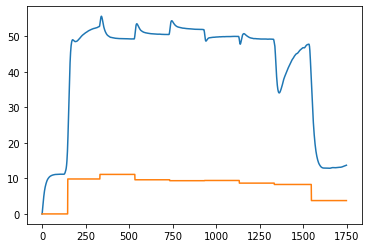

In [194]:
plt.plot(nn_preln_best.containers['OSN-Axt to PN'].recorder.I[0])
plt.plot(pn_I_ss[0,::100])

In [1]:
"""Brute Force Search Over All Parameter Space"""
import io
import numpy as np
from datetime import datetime
import pandas as pd
import pycuda.autoinit
import inspect
import matplotlib as mpl
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from neural.network import Network
from sklearn.metrics import pairwise_distances
import neural.plot as nplt
from neural.utils import generate_stimulus
from itertools import product
from tqdm import tqdm

from example_model_and_params import *

from antennal_lobe.experiments.data import decompose_signal

In [2]:
def ang_dist(X, Y=None, paired=False):
    if Y is None:
        Y = X
    if paired is True:
        from sklearn.metrics.pairwise import paired_distances as metric_func
        positive_mask = np.logical_and(np.all(X >= 0, axis=1), np.all(Y >= 0, axis=1))
        zero_mask = np.logical_or(np.all(X == 0, axis=1), np.all(Y == 0, axis=1))
    else:
        from sklearn.metrics import pairwise_distances as metric_func
        positive_mask = np.logical_and(np.all(X >= 0, axis=1), np.all(Y >= 0, axis=1))
        zero_mask = np.logical_or(np.all(X == 0, axis=1), np.all(Y == 0, axis=1))
    cos_sim = np.atleast_1d(np.squeeze(1.0 - metric_func(X=X, Y=Y, metric="cosine")))
    dists = np.arccos(cos_sim) / np.pi
    dists[positive_mask] *= 2
    dists[zero_mask] = np.inf
    return dists

### Loading I/O

In [3]:
df_aff = pd.read_csv('../data/estimated_affinity.csv', index_col=0)
data = np.load('../data/staircase.npz', allow_pickle=True)
t = data['t']
stim = data['pn_input'][2]
pn = data['pn_output'][2]
dt = t[1] - t[0]

# pn = sm.nonparametric.lowess(exog=t[::100], endog=pn[::100], frac=.01, xvals=t).T

aff = df_aff.loc['acetone'].values # affinity rate of acetone
aff2 = df_aff.loc['ethyl acetate'].values
dr = 10. # dissociation rate fixed
N_r = len(aff) # N_r: number of receptors

In [4]:
def decompose_signal(
    t,
    stim,
    out,
    rec_rate=1,
    axis=-1,
    contrast_eps=1.0,
    ss_window=0.5,
    clip=False,
    peak_offset=.2,
    ss_std=.2,
    start_t = None,
    end_t = None
):
    from scipy.signal import butter, lfilter, find_peaks
    dt = t[1] - t[0]
    if start_t is None:
        start_t = t[0]
    if end_t is None:
        end_t = t[-1]
    b, a = butter(5, 15, fs=1 / dt)
    stim_smooth = lfilter(b, a, np.clip(stim, 0, np.inf), axis=axis)
    d_stim = np.diff(stim_smooth, axis=axis, prepend=stim_smooth[:, [0]]) / dt
    contrast_stim = d_stim / (contrast_eps + stim_smooth)
    pos_peaks_contrast = np.sort(
        np.concatenate(
            [
                find_peaks(
                    contrast_stim[0], height=2.5, width=100, distance=int(1.7 // dt)
                )[0],
                find_peaks(
                    -contrast_stim[0], height=2.5, width=100, distance=int(1.7 // dt)
                )[0],
            ]
        )
    )
    pos_peaks_contrast = (
        pos_peaks_contrast[
            np.logical_and(t[pos_peaks_contrast] > start_t, t[pos_peaks_contrast] < end_t)
        ]// rec_rate
    ).astype(int)
    ss = np.zeros_like(out)
    ss[:, : pos_peaks_contrast[0]] = 0  # out[:,:pos_peaks_contrast[0]].mean(1)[:,None]
    ss[
        :, pos_peaks_contrast[-1] :
    ] = 0  # out[:,pos_peaks_contrast[-1]:].mean(1)[:,None]
    ss_vals = np.zeros((out.shape[0], len(pos_peaks_contrast) - 1))
    pos_peaks_contrast = pos_peaks_contrast - int(peak_offset // (dt * rec_rate))
    for n, (start_idx, stop_idx) in enumerate(
        zip(pos_peaks_contrast[:-1], pos_peaks_contrast[1:])
    ):
        avg_window = slice(stop_idx - int(ss_window // (dt * rec_rate)), stop_idx)
        window = slice(start_idx, stop_idx)
        ss_amp = out[:, avg_window].mean(axis=1)
        ss_vals[:, n] = ss_amp
        tmp = out[:, window].copy()
        for n, (v, a) in enumerate(zip(tmp, ss_amp)):
            mask = np.abs(v - a) > np.abs(a * ss_std)
            v[mask] = a
            ss[n, window] = v

    pk = out - ss
    if clip:
        # trim the peak responses
        pk[:, t[::rec_rate]<=7.83] = np.clip(pk[:, t[::rec_rate]<=7.83], 0, np.inf)
        pk[:, t[::rec_rate]>7.83] = np.clip(pk[:, t[::rec_rate]>7.83], -np.inf, 0)
    # add residual back to ss so that we still add up to the overall response
    ss = out - pk

    return pos_peaks_contrast, ss_vals, ss, pk

In [5]:
idx, ss_amp, ss, on_off = decompose_signal(t, stim[None,:], pn[None,:], clip=True, ss_window=.4)
ss = ss[0]
on_off = on_off[0]

In [6]:
from antennal_lobe.experiments.data import estimate_current

In [7]:
pn_ref = np.outer(
    np.logical_and(t>=t[idx[0]], t<=t[idx[-1]]),
    (aff/aff.max())*ss_amp.mean()
)
pn_ref_I = estimate_current(
    pn_ref,
    resting=0
)
pn_ref_I = np.ma.masked_array(pn_ref_I, mask=pn_ref_I==0)

In [8]:
channel_mask = np.logical_and(aff>1e-5, pn_ref_I.data.max(0)>0)

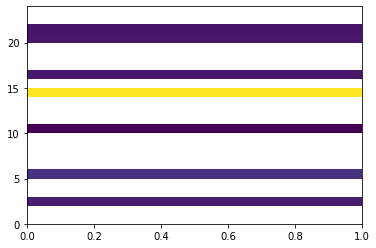

In [9]:
plt.pcolormesh(np.ma.masked_array(aff, aff==1e-5)[None,:].T)

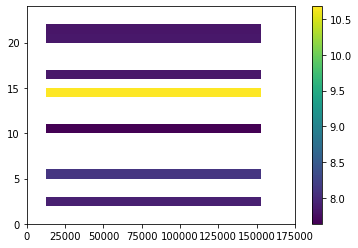

In [10]:
plt.pcolormesh(pn_ref_I.T)
plt.colorbar()

In [11]:
DEFAULT_PARAMS

{'osn_axt': {'a1': 101.6, 'b1': 3.12, 'k': 100000.0},
 'osn-to-preln': {'a1': 1.06, 'b1': 15.5, 'gmax': 3232.6},
 'osn-to-posteln': {'a1': 2.858053089117711,
  'b1': 1.4540529550164887,
  'k': 323039.26691518247,
  'a2': 1.5028414134309191,
  'b2': 98.82274646620965,
  'a3': 8.583048572622092,
  'b3': 5.9266873782378555,
  'gmax': 67918770.0},
 'osn-to-postiln': {'a1': 9.038009011043401,
  'b1': 81.30204837646579,
  'k': 384165.1012001436,
  'a2': 2.094005529791446,
  'b2': 3.657942885692797,
  'a3': 81.35091649546338,
  'b3': 85.33405338413093,
  'gmax': 516779.02440091287},
 'osn_axt-to-pn': {'a1': 1.0, 'b1': 100.0, 'gmax': 122655.1543619},
 'posteln-to-pn': {'a1': 1.0, 'b1': 100.0, 'gmax': 216734.63869500003},
 'postiln-to-pn': {'a1': 1.0, 'b1': 100.0, 'gmax': -25705.851600500002},
 'osn_bsg': {'sigma': 0.0025},
 'pn_bsg': {'sigma': 0.0014},
 'preln_bsg': {'sigma': 0.0},
 'posteln_bsg': {'sigma': 0.0},
 'postiln_bsg': {'sigma': 0.0}}

In [38]:
def run_model(model, params, dt, osn_inp_arr, /, dtype=float, nn=None, sim_rate=1, record_rate=1, verbose=True):
    if np.array(params).ndim == 1:
        params = np.array(params)[:,None]
    Npop = params.shape[1]
    if osn_inp_arr.shape[0] < osn_inp_arr.shape[1]:
        osn_inp_arr = osn_inp_arr.T
    N_r = osn_inp_arr.shape[1]
    Nall = Npop*N_r
    if isinstance(osn_inp_arr, np.ndarray):
        osn_inp_arr = garray.to_gpu(np.ascontiguousarray(osn_inp_arr))
    osn_inp_arr = garray.to_gpu(np.ascontiguousarray((dt*osn_inp_arr.get())[::sim_rate]))

    def _create_network_global_ff(params, dt, osn_inp_arr, /, dtype=float, nn=None, sim_rate=1, record_rate=1, ):
        nn = Network()
        osn_inp = nn.input(num=N_r, name='OSN-inp')
        osn_repeat = nn.add(Repeat, num=Nall, rep_size=Npop, name='BSG')

        osn_axt = nn.add(dDNP, num=Nall, a1=100., b1=params['b1'], k=params['kappa'], name="OSN-Axt")
        preln_syn = nn.add(IonSyn, num=Nall, a1=1., b1=10., gmax=params['gmax'], name="OSN to PreLN")
        preln_agg = nn.add(PreLN, num=Nall, operation='norm-2', block_size=N_r, name="Pre-LN Input")
        preln = nn.add(PoissonCSN0, num=Nall, name="Pre-LN")
        osn_axt_to_pn = nn.add(IonSyn, num=Nall, name="OSN-Axt to PN", a1=1., b1=100., gmax=1e4)
        
        osn_repeat(input=osn_inp)
        osn_axt(u=osn_repeat.output, l=preln.x)
        preln_syn(u=osn_axt.x1)
        preln_agg(input=preln_syn.I)
        preln(I=preln_agg.output)
        osn_axt_to_pn(u=osn_axt.x1)
        
        preln_syn.record('x1', 'I')
        osn_axt_to_pn.record('x1')
        preln.record('x')
        return nn

#     def _create_network_global_fb(params, dt, osn_inp_arr, /, dtype=float, nn=None, sim_rate=1, record_rate=1, ):
#         nn = Network()
#         osn_inp = nn.input(num=N_r, name='OSN-inp')
#         osn_repeat = nn.add(Repeat, num=Nall, rep_size=Npop, name='BSG')
#         preln = nn.add(PreLNOpt, num=Nall, block_size=N_r, name='PreLN')
#         mod2 = nn.add(
#             Axt_Model2, num=Nall, name='Model 2', **params
#         )
#         pn = nn.add(PoissonCSN0, num=Nall, name='PN', dt=dt*sim_rate)

#         osn_repeat(input=osn_inp)
#         preln(input=mod2.x1)
#         mod2(stimulus=osn_repeat.output, f=preln.output)
#         pn(I=mod2.u)
#         mod2.record('x1', 'x2', 'u')
#         pn.record('x')
#         osn_repeat.record('output')
#         preln.record('output')

#         return nn

#     def _create_network_local_ff(params, dt, osn_inp_arr, /, dtype=float, sim_rate=1, record_rate=1, nn=None):
#         nn = Network()
#         osn_inp = nn.input(num=1, name='OSN-inp')
#         osn_repeat = nn.add(Repeat, num=Npop, rep_size=Npop, name='BSG')
#         mod2 = nn.add(
#             Axt_Model2_local_FF, num=Npop, name='Model 2', **params
#         )
#         pn = nn.add(PoissonCSN0, num=Npop, name='PN', dt=dt*sim_rate)
#         osn_repeat(input=osn_inp)
#         mod2(stimulus=osn_repeat.output)
#         pn(I=mod2.u)

#         mod2.record('x1', 'x2', 'u')
#         pn.record('x')

#         return nn

#     def _create_network_local_fb(params, dt, osn_inp_arr, /, dtype=float, sim_rate=1, record_rate=1, nn=None):
#         nn = Network()
#         osn_inp = nn.input(num=1, name='OSN-inp')
#         osn_repeat = nn.add(Repeat, num=Npop, rep_size=Npop, name='BSG')
#         mod2 = nn.add(
#             Axt_Model2_local_FB, num=Npop, name='Model 2', **params
#         )
#         pn = nn.add(PoissonCSN0, num=Npop, name='PN', dt=dt*sim_rate)

#         osn_repeat(input=osn_inp)
#         mod2(stimulus=osn_repeat.output)
#         pn(I=mod2.u)
#         mod2.record('x1', 'x2', 'u')
#         pn.record('x')

#         return nn

    func = locals()[f"_create_network_{model}"]

    params_dct = dict()
    if 'local' in model:
        params_arr = [np.ascontiguousarray(p) for p in params]
    else:
        params_arr = [np.ascontiguousarray(np.tile(p, N_r)) for p in params]

    
    if model in ['global_ff', 'global_fb']:
        params_keys = ['b1', 'kappa', 'gmax']
        params_dct = {key:val for key,val in zip(params_keys, params_arr)}
    else:
        raise ValueError

    nn = func(
        params_dct,
        dt,
        osn_inp_arr,
        dtype=dtype,
        nn=nn,
        sim_rate=sim_rate,
        record_rate=record_rate
    )

    nn.compile(dtype=dtype)
    nn.inputs['OSN-inp'](osn_inp_arr)
    nn.run(dt*sim_rate, verbose=verbose, rate=record_rate)
    return nn

In [39]:
def sample_params(N, bounds):
    params = []
    for lb, ub in bounds: 
        p = np.random.rand(N)
        params.append(p * (ub - lb) + lb)
    return np.vstack(params)

In [40]:
params_all = 10 ** sample_params(
    3000, 
    [(-1, 0), (3, 5), (5, 7)]
)
params_dct = {
    var:p
    for var,p in zip(
        ['b1', 'kappa', 'gmax'],
        params_all
    )
}

In [41]:
osn_inp = np.load('osn_inp.npz')['osn']

In [42]:
rec_rate = 100
nn = run_model('global_ff', params_all, dt, osn_inp, record_rate=rec_rate)

/mnt/server-home/tingkai/Project/NEURAL/neural/neural/network/network.py:324: UserWarning: Size mismatches: BSG(72000) <- OSN-inp(24)
  warnings.warn(


  0%|          | 0/175000 [00:00<?, ?it/s]

In [43]:
x1 = nn.containers['OSN-Axt to PN'].recorder.x1.reshape((N_r, -1, len(t[::rec_rate])))
preln_x = nn.containers['Pre-LN'].recorder.x.reshape((N_r, -1, len(t[::rec_rate])))
preln_inp = nn.containers['OSN to PreLN'].recorder.I.reshape((N_r, -1, len(t[::rec_rate])))

In [62]:
from antennal_lobe.experiments.data import estimate_spike_rate

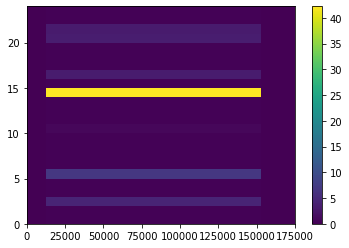

In [67]:
plt.pcolormesh(pn_ref.T)
plt.colorbar()

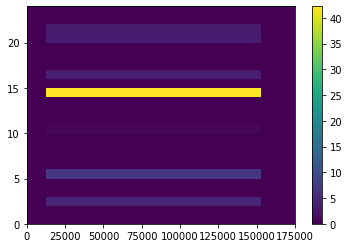

In [66]:
%matplotlib inline
plt.pcolormesh(estimate_spike_rate(pn_ref_I, resting=0).T)
plt.colorbar()

In [44]:
dists = np.empty(x1.shape[1])
mask = ~pn_ref_I.mask[::rec_rate]
for i in tqdm(range(x1.shape[1])):
    d = ang_dist(x1[channel_mask,i].T, pn_ref_I[::rec_rate,channel_mask], paired=True)
    dists[i] = d[np.isfinite(d)].mean()

100%|██████████| 3000/3000 [00:04<00:00, 713.14it/s]


In [51]:
plt.figure()
plt.plot(x1[14,np.argmi
            n(dists)])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

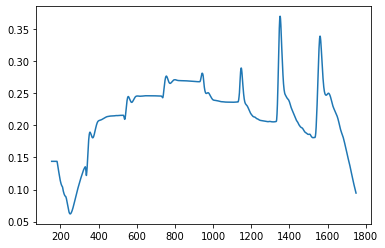

In [91]:
plt.plot(ang_dist(estimate_spike_rate(95557625.8852926* x1[:,np.argmin(dists)], resting=0).T, aff[None,:]))

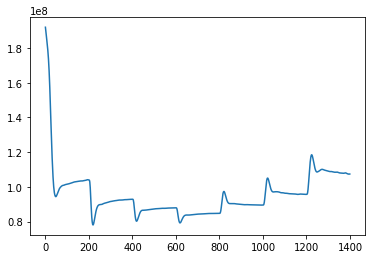

In [83]:
plt.plot(pn_ref_I[:, 14][~pn_ref_I[:, 14].mask][::100][:-1]/x1[14, np.argmin(dists)][~pn_ref_I[:, 14].mask[::rec_rate]])

In [70]:
pn_ref_I[14] x1[:,np.argmin(dists)][14]

array([5.11085315e-14, 1.93577127e-10, 5.91690067e-10, ...,
       8.27704245e-08, 8.27659578e-08, 8.27596965e-08])

In [58]:
plt.figure()
plt.plot(ang_dist(x1[:,np.argmin(dists)].T, aff[None,:]))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [49]:
plt.figure()
plt.pcolormesh(x1[:,np.argmin(dists)])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [45]:
%matplotlib widget
fig,ax = plt.subplots(1,1,subplot_kw=dict(projection='3d'))
cax = ax.scatter(*np.log10(params_all), c=dists, alpha=.5)
ax.set(xlabel='b1', ylabel='kappa', zlabel='gmax')
plt.colorbar(cax)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

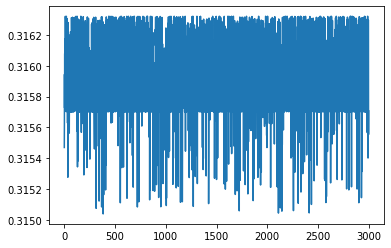

In [106]:
plt.plot(dists)

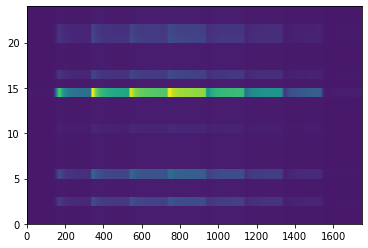

In [62]:
plt.pcolormesh(x1[:,-1])

In [ ]:
import argparse
import os
import json
import warnings
from tensorboardX import SummaryWriter
warnings.filterwarnings("ignore")

parser = argparse.ArgumentParser(description='Brute Force Model Parameter Search')
parser.add_argument(
    '--model',
    type=str,
    choices=['global_ff', 'global_fb', 'global_fffb', 'local_ff', 'local_fb', 'local_fffb'],
    help='Model Name'
)
parser.add_argument('-dt', default=1e-4, type=float, help="Time Resolution")
parser.add_argument('-sr', '--sim_rate', default=1, type=int, help="Simulation Rate")
parser.add_argument('-rr', '--rec_rate', default=10, type=int, help="Record Rate")
parser.add_argument('-Ns', '--N_samples', default=100, type=int, help="Number of samples in each dimension of the parameter set")
parser.add_argument('-bs', '--batch_size', default=5000, type=int, help="Number of parameters to run at the same time")
parser.add_argument('--max_samples', default=int(1e8), type=int, help="Maximum number of possible samples")
parser.add_argument('-v', '--verbose', default=True, type=bool, help="Verbose")
args,_ = parser.parse_known_args()
cfg = dict(json.load(open('./optimization_config.json', 'r')))

""" Load Data """
CURR_DIR = os.path.dirname(os.path.abspath(__file__))
physio_data_dir = os.path.join(os.path.dirname(os.path.dirname(CURR_DIR)), 'physio_data')
phys_data = dict(np.load(os.path.join(physio_data_dir, 'ant_al_io.npz'), allow_pickle=True))
pn_data = dict(np.load(os.path.join(physio_data_dir, 'pn_data.npz'), allow_pickle=True))
for key,val in pn_data.items():
    try:
        pn_data[key] = val.item()
    except:
        pass

door_est = pd.read_csv(os.path.join(physio_data_dir, 'estimated_affinity.csv'), index_col=0)

t_orig = phys_data['t']
t_sim = np.arange(t_orig.min(), t_orig.max()+args.dt/2, args.dt)
stim = np.interp(t_sim, t_orig, phys_data['stim'][0])[None,:]
ref = np.interp(t_sim, t_orig, phys_data['pn'][0])[None,:]
osn_bsg_acetone = np.load('../tmp_full.npz')['osn']
I_59b = estimate_current(ref, resting=0)

""" Creat Parameters """
bounds = np.array(cfg["bounds"][args.model])
params = np.array(list(product(
    *[np.linspace(bd[0], bd[1], args.N_samples) for bd in bounds]
))).T
if params.shape[1] > args.max_samples:
    warnings.warn(
        f"Actual number of parameters ({params.shape[1]}) is larger than "
        f"max ({args.max_samples})"
    )
params = params[:, :args.max_samples]
df_res = pd.DataFrame(
    {
        **{f"param-{n}":p for n,p in enumerate(params)},
        **{
            "angular_59b":np.full(params.shape[-1], -np.inf),
            "snr_59b":np.full(params.shape[-1], -np.inf),
            "l2_59b":np.full(params.shape[-1], -np.inf),
            "avg_pn_dist":np.full(params.shape[-1], -np.inf),
        }
    }
)

best_params_overall = None
best_angular_overall = np.inf
logdir = f"brute_runs/{args.model}-{datetime.now().strftime('%b%d_%H-%M-%S')}"
res_dir = os.path.join(logdir, 'results')
with SummaryWriter(logdir) as wrt:
    wrt.add_text('model', args.model, 0)
    if not os.path.exists(res_dir):
        os.mkdir(res_dir)

    pbar = tqdm(
        enumerate(np.arange(params.shape[1])[::args.batch_size]),
        total=len(np.arange(params.shape[1])[::args.batch_size]),
        desc=f"{args.model}|{params.shape[1]}"
    )
    for n_it, start in pbar:
        stop = min(start+args.batch_size, params.shape[1])
        params_batch = params[:, start:stop]
        nn = run_model(
            args.model,
            params_batch,
            args.dt,
            osn_bsg_acetone,
            sim_rate=args.sim_rate,
            record_rate=args.rec_rate,
            verbose=False
        )

        if n_it == 0:
            wrt.add_text(
                'model source',
                inspect.getsource(nn.containers['Model 2'].obj.__class__),
                n_it
            )

        mod_x1 = nn.containers['Model 2'].recorder.x1
        if 'global' in args.model:
            mod_x1 = mod_x1.reshape((door_est.shape[1], -1, mod_x1.shape[-1]))[14]

        best_gmax_all = find_best_gmax_all(
            mod_x1,
            ref[:, ::args.sim_rate*args.rec_rate],
            mask=np.logical_and(t_sim>5, t_sim<20)[::args.sim_rate*args.rec_rate],
            est_rate=100
        )
        pn_x = estimate_spike_rate(
            best_gmax_all[:,None] * mod_x1,
            resting=0
        )

        ang_dist = np.atleast_1d(np.squeeze(angular_dist(
            pn_x,
            ref[:,::args.sim_rate*args.rec_rate]
        )))
        # mask = (I_59b >= 7.6)[0, ::args.sim_rate*args.rec_rate]
        # ang_dist = np.atleast_1d(np.squeeze(angular_dist(
        #     mod_x1[:, mask],
        #     I_59b[:,::args.sim_rate*args.rec_rate][:,mask]
        # )))


        x1_too_large = mod_x1.max(-1) > 0.8
        snr_all = np.squeeze(average_snr(
            ref[:, ::args.sim_rate*args.rec_rate],
            pn_x,
            axis=1
        ))
        l2_all = np.squeeze(np.linalg.norm(
            ref[:, ::args.sim_rate*args.rec_rate] -
            pn_x,
            axis=1
        ))

        valid_mask= np.logical_not(x1_too_large)
        best_param_idx = np.arange(len(snr_all))[valid_mask][np.argmax(snr_all[valid_mask])]
        best_mod1 = mod_x1[best_param_idx]
        best_ang = ang_dist[best_param_idx]
        best_params = params_batch[:, best_param_idx]
        best_gmax = best_gmax_all[best_param_idx]
        best_59b = pn_x[best_param_idx]
        best_snr = snr_all[best_param_idx]
        best_l2 = l2_all[best_param_idx]

        # best_param_idx = np.argmin(ang_dist + x1_too_large.astype(float))
        # best_mod1 = mod_x1[best_param_idx]
        # best_ang = ang_dist[best_param_idx]
        # best_params = params_batch[:, best_param_idx]
        # best_gmax = get_best_scale(best_mod1, ref[0], sim_rate=args.sim_rate, rec_rate=args.rec_rate, est_rate=1)
        # best_59b = estimate_spike_rate(best_gmax * best_mod1, resting=0)
        # best_snr = average_snr(ref[0][::args.sim_rate*args.rec_rate], best_59b)
        # best_l2 = np.linalg.norm(ref[0][::args.sim_rate*args.rec_rate] - best_59b)

        if best_params_overall is None:
            best_params_overall = best_params
            best_angular_overal = best_ang
            best_snr_overall = best_snr
            best_l2_overall = best_l2
        else:
            if best_ang < best_angular_overal:
                best_params_overall = best_params
                best_l2_overall = best_l2
                best_snr_overall = best_snr
                best_angular_overall = best_ang

        wrt.add_scalar('Ang. 59b', best_angular_overall, n_it)
        wrt.add_scalar('ASNR 59b', best_snr_overall, n_it)
        wrt.add_scalar('l2 59b', best_l2_overall, n_it)
        wrt.add_scalars(
            'params',
            {
                **{f'param-{n}': p for n,p in enumerate(best_params_overall)},
                **{'gmax': best_gmax}
            },
            n_it
        )
        pbar.set_description(f"{args.model} | {params.shape[1]} | Ang {best_angular_overal:.3f} | SNR {best_snr_overall:.1f} dB | l2 {best_l2_overall:.1f}")

        df_res.loc[df_res.index[start:stop], "angular_59b"] = ang_dist
        df_res.loc[df_res.index[start:stop], "valid"] = valid_mask
        df_res.loc[df_res.index[start:stop], "snr_59b"] = snr_all
        df_res.loc[df_res.index[start:stop], "l2_59b"] = l2_all

        fig,axes = plt.subplots(2,1,figsize=(8,6), sharex=True)
        ax = axes[0]
        ax.plot(
            t_sim[::args.sim_rate*args.rec_rate],
            best_mod1*best_gmax,
            c='r',
            label=f"Ang={best_ang:.3f}"
        )
        ax.plot(t_sim, I_59b[0], '-k', alpha=.6, label='Current')

        ax = axes[1]
        ax.plot(
            t_sim[::args.sim_rate*args.rec_rate],
            best_59b,
            c='r',
            label=f"SNR={best_snr:.1f} dB, l2={best_l2:.1f}"
        )
        ax.plot(t_sim, ref[0], '-k', alpha=.6, label='Physiology Data')

        for ax in axes:
            ax.grid()
            ax.legend()
        axes[0].set_ylabel("Current [$\mu A$]")
        axes[1].set_ylabel("PSTH [Hz]")
        axes[0].set_title(args.model)
        wrt.add_figure('Or59b Result', fig, n_it)

        affs = door_est.values
        concs = 10**np.linspace(0,4,30)
        mixture_ratios = np.vstack([np.eye(110)*c for c in concs])
        N_w, N_odorants = mixture_ratios.shape
        N_r = affs.shape[1]
        wav = generate_stimulus('step', args.dt, 3., (.0, 3.), 1., sigma=0.)


        if 'fffb' not in args.model:
            model_params = dict(
                a1=best_params[0],b1=best_params[1],kappa=best_params[2],
                a2=best_params[3],b2=best_params[4],
                gmax=best_gmax
            )
        else:
            model_params = dict(
                a1=best_params[0],b1=best_params[1],kappa=best_params[2],
                a2=best_params[3],b2=best_params[4],
                a3=best_params[5],b3=best_params[6],gamma=best_params[7],
                gmax=best_gmax
            )

        nn  = create_network(
            affs,
            mixture_ratios,
            args.dt,
            models=[args.model],
            model_params={args.model:model_params},
            record=False
        )
        for n in range(N_odorants):
            nn.inputs[f'waveform{n}'](wav)
        nn.run(args.dt, verbose=False, rate=args.rec_rate)

        osn_aff_dist = cost_against_affs_ss(
            nn.containers['BSG'].obj.x.reshape(
                (len(concs), N_odorants, N_r)
            ).get() / args.dt,
            door_est.values
        )
        mod_res = nn.containers[args.model].obj.x1.reshape(
            (len(concs), N_odorants, N_r)
        ).get()
        mod_aff_dist = cost_against_affs_ss(mod_res, door_est.values)

        pn_res = nn.containers[f'PN-{args.model}'].obj.x.reshape(
            (len(concs), N_odorants, N_r)
        ).get()/args.dt
        pn_aff_dist = cost_against_affs_ss(pn_res, door_est.values)

        fig, axes = plt.subplots(2, 3+1, figsize=(12,7),gridspec_kw=dict(width_ratios=[10]*3+[1], hspace=.4))
        cs = plt.cm.get_cmap('coolwarm',len(concs))
        for n1, _mod in enumerate(['osn', 'mod', 'pn']):
            nplt.plot_mat(
                globals()[f'{_mod}_aff_dist'],
                y=concs,
                vmin=0, vmax=1,
                ax=axes[0,n1],
                cax=axes[0,-1] if n1==0 else False,
                cbar_kw=dict(label='Distance w.r.t. Affinity'),
                shading='nearest',
                rasterized=True,
                cmap=plt.cm.coolwarm,
            )
            axes[0,n1].set_title(f"{_mod}")
            axes[0,n1].set_yscale('log')
            axes[0,n1].set_xlabel("Odorant Index")

            if n1 == 0:
                axes[0,n1].set_ylabel("Concentration [ppm]")
            else:
                axes[0,n1].set_yticklabels([])
                for n_c, (_out1, _out2) in enumerate(zip(
                    osn_aff_dist,
                    globals()[f'{_mod}_aff_dist']
                )):
                    axes[1,n1].scatter(
                        _out1,
                        _out2,
                        c=[cs(n_c)],
                        s=1,
                        alpha=.5,
                        rasterized=True
                    )
                axes[1,n1].plot([0,1], [0,1], c='k')
                axes[1,n1].axis('square')
                axes[1,n1].set_xlim([-0.1,1.1])
                axes[1,n1].set_ylim([-0.1,1.1])
                axes[1,n1].grid()
                axes[1,n1].set_xlabel("$d(OSN, Aff.)$")
                axes[1,n1].set_ylabel(f"$d({_mod.upper()}, Aff.)$")
        axes[1,0].remove()
        norm = mpl.colors.BoundaryNorm(concs, plt.cm.coolwarm.N)
        cb = mpl.colorbar.ColorbarBase(
            axes[1,-1], cmap=plt.cm.coolwarm, norm=norm,
            spacing='proportional', ticks=concs, boundaries=concs
        )
        axes[1,-1].set_yscale('log')
        fig.suptitle(args.model, fontsize=15)

        wrt.add_figure('Affinity Distance', fig, n_it)

        df_res.loc[df_res.index[start:stop][best_param_idx], "avg_pn_dist"] = np.mean(pn_aff_dist[np.isfinite(pn_aff_dist)])
        df_res.to_csv(f"{logdir}/results.csv")
        np.savez(
            os.path.join(res_dir, f'iter_{n_it}'),
            **dict(
                params=params_batch,
                best_params = best_params,
                best_ang = best_ang,
                best_snr = best_snr,
                best_l2 = best_l2,
                best_gmax = best_gmax,
                best_mod1 = best_mod1,
                best_59b = best_59b,
                pn_res = pn_res,
                osn_aff_dist=osn_aff_dist,
                pn_aff_dist = pn_aff_dist,
                mod_res = mod_res,
                mod_aff_dist = mod_aff_dist,
                start_idx=start,
                stop_idx=stop
            )
        )